In [35]:
import nltk 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import re
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV 
from nltk.tokenize import punkt  
from nltk.corpus import stopwords 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
!pip install contractions
import contractions 
import string


In [2]:
pd.set_option('display.max_colwidth',100)
# Load training set 
raw_ = pd.read_csv('text-data/train.csv')
raw_.head(30)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAf...,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [3]:
raw_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
# split data into training and test 
X_train, X_test, y_train, y_test = train_test_split(raw_[['text']],raw_['target'],random_state=42)
print(X_train.shape, X_test.shape)
X_train[50:70]

(5709, 1) (1904, 1)


,text
1934,Next May I'll be free...from school from obligations like family.... Best of all that damn curfe...
5345,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) @... http://t.co/JbxBi93CLu
6359,NTSB: Virgin Galactic crash caused by structural failure triggered when brakes unlocked early ht...
3882,Zouma has just absolutely flattened that guy ??
4756,Don't blink ?? won't see the Lightning take the W ?? http://t.co/D4c2iqiRnU
5062,anyway 2 me? Mateo just doesnt exist? Hes a mirage a pointless addition to our Generation. a hum...
1203,The greatest female beat boxer ever now but it's w/e... Save babies outta burning buildings on m...
2550,If Shantae doesn't get in Smash I will destroy my Wii U.\n#ShantaeForSmash #Shantae #ShantaeHalf...
969,?? New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/...
1805,Police respond to crash find 'suspected heroin' http://t.co/oJoecW29qa


In [5]:
# Exploring what the unique keywords and locations are 
non_null_kw = raw_.keyword.notnull()
non_null_loc = raw_.location.notnull()
raw_['keyword'][non_null_kw].unique()[:30]

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags'], dtype=object)

In [6]:
raw_['location'][non_null_loc].unique()[:30]

array(['Birmingham', 'Est. September 2012 - Bristol', 'AFRICA',
       'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!',
       'Paranaque City', 'Live On Webcam', 'milky way',
       'GREENSBORO,NORTH CAROLINA', 'England.',
       'Sheffield Township, Ohio', 'India', 'Barbados', 'Anaheim',
       'Abuja', 'USA', 'South Africa', 'Sao Paulo, Brazil',
       'hollywoodland ', 'Edmonton, Alberta - Treaty 6',
       'Inang Pamantasan', 'Twitter Lockout in progress', 'Concord, CA',
       'Calgary, AB', 'San Francisco', 'CLVLND', 'Nashville, TN',
       'Santa Clara, CA'], dtype=object)

In [27]:
raw_['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

#### Feature creation and evaluation 
Its worthwhile thinking about what kind of features could be useful in better predicting disasters. 

In [7]:
# create a data cleaning function that tokenizes, 
# removes english stopwords and punctuations and returns tokenized text in lowercase 

def clean_text_lm(text):
    '''Removes punctuations and stopwords and returns lowercase tokenized text for input text and pattern'''
    
    # expand contracted sentences
    doc = contractions.fix(text) 
    eng_stop = stopwords.words('english') # english stopwords
    wn = nltk.WordNetLemmatizer() # Instantiate word lemmatizer
    # match regex pattern and replace with empty string
#     doc_nousr = re.sub(r'@[^\s]+',r'',doc)
    doc_nourl = re.sub(r'(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+',r'',doc)
    doc_nospchar = re.sub(r'^a-zA-Z\s\W+',r'',doc_nourl,re.I | re.A) 
    
    # remove punctuations from previous out
    doc_nopunct = ''.join([char for char in doc_nospchar if char not in string.punctuation])
    
    # convert text to lower case and strip white space if any
    doc_lower_nospc = doc_nopunct.lower().strip() 
    
    # lemmatize and store in list format
    lem_text = [wn.lemmatize(word) for word in re.split('\W+',doc_lower_nospc)] 
    
     # join list into string with no stopwords
    no_stop_docs = ' '.join([word for word in lem_text if word not in eng_stop])
    
    return no_stop_docs
    
    

In [8]:
# Vectorize the function to apply accross dataframe
cleaner = np.vectorize(clean_text_lm)
# store values in separate column in df
X_train['cleaned_text'] = cleaner(X_train[['text']])
X_train[50:70]


,text,cleaned_text
1934,Next May I'll be free...from school from obligations like family.... Best of all that damn curfe...,next may school obligation like best damn
5345,Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) @... http://t.co/JbxBi93CLu,pandemonium aba woman delivers baby without face photo
6359,NTSB: Virgin Galactic crash caused by structural failure triggered when brakes unlocked early ht...,ntsb virgin galactic crash caused structural failure triggered brake unlocked early
3882,Zouma has just absolutely flattened that guy ??,zouma ha absolutely flattened guy
4756,Don't blink ?? won't see the Lightning take the W ?? http://t.co/D4c2iqiRnU,blink see lightning take w
5062,anyway 2 me? Mateo just doesnt exist? Hes a mirage a pointless addition to our Generation. a hum...,anyway 2 mateo doe exist mirage pointless addition generation human natural disaster sorry true
1203,The greatest female beat boxer ever now but it's w/e... Save babies outta burning buildings on m...,greatest female beat boxer ever save baby outta burning building free time ya
2550,If Shantae doesn't get in Smash I will destroy my Wii U.\n#ShantaeForSmash #Shantae #ShantaeHalf...,shantae doe get smash destroy wii shantaeforsmash shantae shantaehalfgeniehero nintendo
969,?? New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/...,new lady shoulder tote handbag faux leather hobo purse cross body bag woman
1805,Police respond to crash find 'suspected heroin' http://t.co/oJoecW29qa,police respond crash find suspected heroin


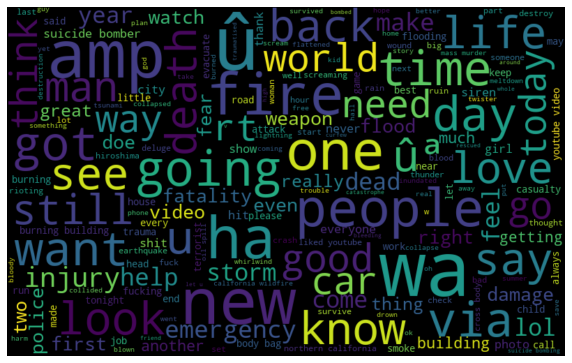

In [25]:
from wordcloud import WordCloud
# Generate word cloud
all_words = ' '.join([text for text in X_train['cleaned_text']])
wordcloud = WordCloud(width=800, height = 500, max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


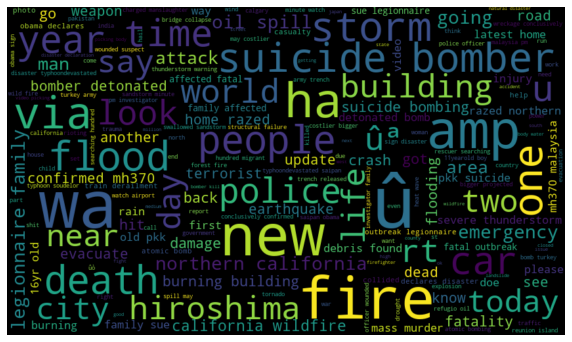

In [29]:
raw_['cleaned_text'] = cleaner(raw_['text'])
disaster_words = ' '.join(word for word in raw_['cleaned_text'][raw_['target']==1])
wordcloud = WordCloud(width=850, height=500, max_font_size=110).generate(disaster_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

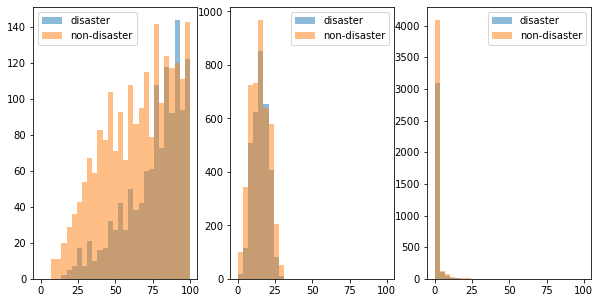

In [23]:
# Length of text 
raw_['doc_len'] = raw_['text'].apply(len)
raw_['word_count'] = raw_['text'].apply(lambda x: len(x.split()))
# Number of caps per tweet 
raw_['CAPS_len'] = raw_['text'].apply(lambda x: 
                                   len([word for word in x.split() if word.isupper()])
                                  )

bins = np.linspace(0, 100, 30)
features_ = raw_.columns 
targets_ = y_train.unique()
# create subplots, figsize to control size of the image
fig, ax = plt.subplots(1,3, figsize=(10,5)) 
# plt.subplot(1,3,1) # 1 line, 2 rows, index nr 1 (first position in the subplot)
ax[0].hist(raw_[raw_['target']==1]['doc_len'], bins, alpha=0.5, label='disaster')
ax[0].hist(raw_[raw_['target']==0]['doc_len'], bins, alpha=0.5, label='non-disaster')
ax[0].legend(loc='best')
# plt.subplot(1, 3, 2) 
ax[1].hist(raw_[raw_['target']==1]['word_count'], bins, alpha=0.5, label='disaster')
ax[1].hist(raw_[raw_['target']==0]['word_count'], bins, alpha=0.5, label='non-disaster')
ax[1].legend(loc='best')
# plt.subplot(1,3,3)
ax[2].hist(raw_[raw_['target']==1]['CAPS_len'], bins, alpha=0.5, label='disaster')
ax[2].hist(raw_[raw_['target']==0]['CAPS_len'], bins, alpha=0.5, label='non-disaster')
ax[2].legend(loc='best')
plt.show()

The cleaned text is now devoid of any special characters or stopwords, however its still not ready to be vectorized. The first action required is to tokenize the words, ie, converting the sentence into a list of words, and then, there can be many words that have a similar meaning such search, searching, searched, etc. I used a lemmatizer (WordNetLemmatizer) to correlate words with similar meaning and keeps the root words. 

In [13]:
# transform test set to vectorized format
X_test['cleaned_text'] = cleaner(X_test[['text']])
X_test.head()

,text,cleaned_text
2644,So you have a new weapon that can cause un-imaginable destruction.,new weapon unimaginable destruction
2227,The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons...,famping thing gishwhes got soaked deluge going pad tampon thx mishacollins
5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool St...,dt georgegalloway rt galloway4mayor ûïthe col police catch pickpocket liverpool
132,Aftershock back to school kick off was great. I want to thank everyone for making it possible. W...,aftershock back school kick wa great want thank everyone making possible great night
6845,in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerab...,response trauma child addict develop defensive self one decrease vulnerability 3


In [14]:
# Instantiate CountVectorizer
CountVec = CountVectorizer(analyzer = 'word',ngram_range = (1,1))
# convert text to matrix of token counts
train_cmatrix = CountVec.fit_transform(X_train['cleaned_text']).toarray()
# convert count matrix to dataframe
train_cmatrix_df = pd.DataFrame(train_cmatrix, columns = CountVec.get_feature_names() )

# performing similar steps on test data
test_cmatrix = CountVec.transform(X_test['cleaned_text']).toarray()
test_cmatrix_df = pd.DataFrame(test_cmatrix,columns = CountVec.get_feature_names())


#### Classification of tweets 

In [33]:
# Instantiate classifier
rf_clf = RandomForestClassifier(random_state=42,n_jobs=-1)
# fit the model 
rf_model = rf_clf.fit(train_cmatrix, y_train)
# predict on test 
y_hat = rf_model.predict(test_cmatrix)
# evaluate model 
print(classification_report(y_test, y_hat))
confusion_ = pd.DataFrame(confusion_matrix(y_test, y_hat),index=['non-disaster','disaster'])
print(confusion_)

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1091
           1       0.81      0.66      0.73       813

    accuracy                           0.79      1904
   macro avg       0.79      0.77      0.78      1904
weighted avg       0.79      0.79      0.78      1904

                0    1
non-disaster  966  125
disaster      278  535


#### Hyperparameter tuning 
While the performance using default parameters of the classifier yielded decent scoring in precision, recall and f1-score, we should try to see what would be configuration would provide the best score possible using the RandomForest classifier. To do this, we will use grid search cross validation to determine these parameters. 

In [17]:
# Find best params
params = {'criterion':['gini','entropy'],
          'n_estimators':[50,100,150], 
          'max_depth':[20,50,75,100,None]
         }
rf = RandomForestClassifier(random_state=42)
gs = GridSearchCV(rf ,param_grid = params ,cv = 5, scoring='accuracy', n_jobs=-1)
gs.fit(train_cmatrix,y_train)
grid_pred = gs.predict(test_cmatrix)
best_params = gs.best_params_
print("Best params: {}\n Best Score: {}".format(best_params,gs.best_score_))
print(classification_report(y_test,grid_pred))


Best params: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}
 Best Score: 0.7847264282567754
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1091
           1       0.81      0.65      0.72       813

    accuracy                           0.79      1904
   macro avg       0.79      0.77      0.77      1904
weighted avg       0.79      0.79      0.78      1904



Looks like default parameters are best for the classification using RandomForest. Trying out other classifiers and vectorizing methods to see if we can get better results

In [58]:
# steps = [('Cvect',CountVec),
#          ('rf',rf)]
# pipeline = Pipeline(steps=steps)
rf_param_grid = {'criterion':['gini','entropy'],
          'n_estimators':np.arange(50, 250, 50), 
          'max_depth':np.arange(20, 500, 25)
         }
# Randomizedgridsearch
rf_randomizedcv_roc_auc = RandomizedSearchCV(rf, 
                                        param_distributions=rf_param_grid,
                                        n_iter=1, 
                                        scoring="roc_auc", 
                                        verbose=1, 
                                        cv=5,
                                         n_jobs=-1)
rf_randomizedcv_roc_auc.fit(train_cmatrix,y_train)
print(rf_randomizedcv_roc_auc.best_score_)
print(rf_randomizedcv_roc_auc.best_estimator_)
# Bayesianoptimization 


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.0s finished


0.8418283019001155
RandomForestClassifier(max_depth=70)


In [59]:
# Rerun RF classifier with optimized parameters
rf_clf = RandomForestClassifier(max_depth = 70,random_state=42,verbose=1,n_jobs = -1)

# fit the model 
rf_model = rf_clf.fit(train_cmatrix, y_train)
# predict on test 
y_hat = rf_model.predict(test_cmatrix)
# evaluate model 
print(classification_report(y_test, y_hat))
confusion_ = pd.DataFrame(confusion_matrix(y_test, y_hat),index=['non-disaster','disaster'])
print(confusion_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s


              precision    recall  f1-score   support

           0       0.72      0.95      0.82      1091
           1       0.88      0.52      0.65       813

    accuracy                           0.76      1904
   macro avg       0.80      0.73      0.74      1904
weighted avg       0.79      0.76      0.75      1904

                 0    1
non-disaster  1036   55
disaster       394  419


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


AUC for Class 1: 0.8496239499516901


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


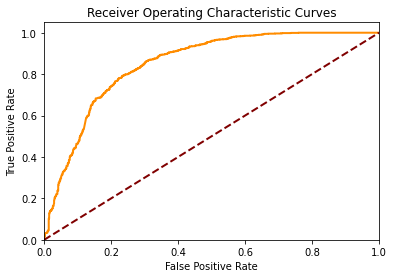

In [70]:
#Calculate the y_score
rf_y_score = rf_model.predict_proba(test_cmatrix)

from sklearn.preprocessing import label_binarize
#Binarize the output
rf_y_test_bin = label_binarize(y_test, classes=[1,0])
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
#create ROC curve
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(rf_y_test_bin[:, i], rf_y_score[:, i])
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=2)
    print('AUC for Class {}: {}'.format(i+1, auc(fpr[i], tpr[i])))

plt.plot([0, 1], [0, 1], color='maroon', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.show()


##### Analysis of results
Our optimized model was able to distinguish disaster from non-disaster tweets with ~<b>77%</b> accuracy.
<br>
From the confusion matrix, there seems to be a marked difference in the classification of true negatives and positives. However, we also see any improvements in the precision, recall or f1-scores when compared to the default model. We also notice a drastic difference in recall scores between the 0 (non-disaster) and 1 (disaster) labels. One reason might because of the class imbalance in the training dataset. 
<br>
It might be worthwhile to look into other classifiers as well as adding features to improve our classification. 


#### Using TF-IDF vectorizer and XGB classifier 


In [71]:
gb = GradientBoostingClassifier(random_state=42)
tf_vect = TfidfVectorizer(analyzer=clean_text_lm, min_df=2, max_df=0.9)
train_tfidf_matrix = tf_vect.fit_transform(X_train['cleaned_text']).toarray()
test_tfidf_matrix = tf_vect.transform(X_test['cleaned_text']).toarray()
gb.fit(train_tfidf_matrix,y_train)
gb_y_hat = gb.predict(test_tfidf_matrix)
print(classification_report(y_test, gb_y_hat))
confusion_ = pd.DataFrame(confusion_matrix(y_test, gb_y_hat),index=['non-disaster','disaster'])
print(confusion_)

              precision    recall  f1-score   support

           0       0.64      0.85      0.73      1091
           1       0.64      0.36      0.46       813

    accuracy                           0.64      1904
   macro avg       0.64      0.60      0.60      1904
weighted avg       0.64      0.64      0.61      1904

                0    1
non-disaster  927  164
disaster      521  292


In [73]:
gbm_param_grid = {
    'learning_rate': np.arange(0.05, 1, 0.05),
    'max_depth': np.arange(3, 10, 1),
    'n_estimators': np.arange(50, 200, 50)
}
# gb_steps=[('tf',tf_vect),('XGB',gb)]
# gb_pipeline = Pipeline(steps=gb_steps)
# gb_pipeline.fit(train_tfidf_matrix,y_train)
gb_randomizedcv_roc_auc = RandomizedSearchCV(gb, 
                                        param_distributions=gbm_param_grid,
                                        n_iter=1, 
                                        scoring="roc_auc", 
                                        verbose=1, 
                                        cv=5,
                                         n_jobs=-1)
gb_randomizedcv_roc_auc.fit(train_tfidf_matrix,y_train)
grid_pred_gbm = gb_randomizedcv_roc_auc.predict(test_tfidf_matrix)
best_params_gbm = gb_randomizedcv_roc_auc.best_params_
print("Best params: {}\n Best Score: {}".format(best_params_gbm,randomizedcv_roc_auc.best_score_))
print(classification_report(y_test,grid_pred_gbm))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


Best params: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.55}
 Best Score: 0.8387124250961826
              precision    recall  f1-score   support

           0       0.66      0.71      0.69      1091
           1       0.57      0.51      0.54       813

    accuracy                           0.63      1904
   macro avg       0.62      0.61      0.61      1904
weighted avg       0.62      0.63      0.62      1904

